In [1]:
import os 
import pandas as pd 
import torch 

In [2]:
def sliding_window(ts, features):
    X=[]
    Y =[]
    for i in range(features+1, len(ts)+1):
        X.append(ts[i - (features+1): i-1])
        Y.append([ts[i-1]])
    return X, Y


def get_aep_timeseries():
    df = pd.read_csv('/Users/nuthankumar/Downloads/Time-Series-Forecasting-using-Deep-Learning-main/Chapter 04/data/AEP_hourly.csv')
    ts = df['AEP_MW'].astype(int).values.reshape(-1,1)[-3000:]
    return ts 

def get_pjme_timeseries():
    df = pd.read_csv('/Users/nuthankumar/Downloads/Time-Series-Forecasting-using-Deep-Learning-main/Chapter 04/data/PJME_hourly.csv')
    ts = df['PJME_MW'].astype(int).values.reshape(-1,1)[-3000:]
    return ts 

def get_ni_timeseries():
    df = pd.read_csv('/Users/nuthankumar/Downloads/Time-Series-Forecasting-using-Deep-Learning-main/Chapter 04/data/NI_hourly.csv')
    ts = df['NI_MW'].astype(int).values.reshape(-1,1)[-3000:]
    return ts 


def get_training_datasets(ts, features, test_len):
    X, Y =sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len], Y[0:-test_len],\
        X[-test_len:], Y[-test_len:]

    train_len = round(len(ts)*0.7)
    X_train, X_val, Y_train, Y_val = X_train[0:test_len], X_train[test_len:],\
        Y_train[0:test_len:], Y_train[test_len:]

    x_train = torch.tensor(data= X_train).float()
    y_train = torch.tensor(data= Y_train).float()

    x_val = torch.tensor(data= X_val).float()
    y_val = torch.tensor(data= Y_val).float()

    x_test = torch.tensor(data= X_test).float()
    y_test = torch.tensor(data= Y_test).float()

    return x_train, x_val, x_test, y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)

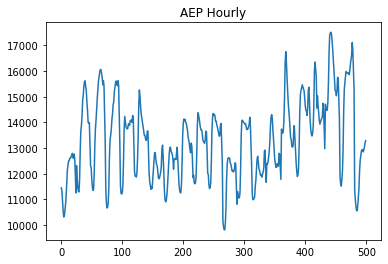

In [3]:
import matplotlib.pyplot as plt 
plt.title('AEP Hourly')
plt.plot(get_aep_timeseries()[:500])
plt.show()

In [4]:
import torch.nn as nn 

class RNN(nn.Module):
    def __init__(self, hidden_size, in_size =1, out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = in_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

In [5]:
class LSTM(nn.Module):
    
    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h

In [6]:
import copy 
import random
import sys 
import numpy as np 
import torch 
from sklearn.preprocessing import MinMaxScaler
random.seed(1)
torch.manual_seed(1)

features = 240

test_ts_len = 300

rnn_hidden_size = 24

learning_rate = 0.02

training_epoch = 500

ts = get_aep_timeseries()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(scaled_ts, features, test_ts_len)

model = RNN(hidden_size = rnn_hidden_size)
model.train()

optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

/var/folders/1w/8h3yk1sx6ksfx6r74wt5vc040000gn/T/ipykernel_14329/387312664.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(data= X_train).float()


In [7]:
for t in range(training_epoch+1):
    
    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 50 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')


epoch 0: train - 0.2422, val: - 0.0371
epoch 50: train - 0.0177, val: - 0.0404
epoch 100: train - 0.0154, val: - 0.0465
epoch 150: train - 0.0122, val: - 0.0354
epoch 200: train - 0.003, val: - 0.0062
epoch 250: train - 0.0019, val: - 0.0023
epoch 300: train - 0.0018, val: - 0.0021
epoch 350: train - 0.0016, val: - 0.0019
epoch 400: train - 0.0015, val: - 0.0018
epoch 450: train - 0.0014, val: - 0.0017
epoch 500: train - 0.0014, val: - 0.0017


In [8]:
best_model.eval()
_, h_list = best_model(x_val)
#warm hidden state
h = (h_list[-1,:]).unsqueeze(-2)

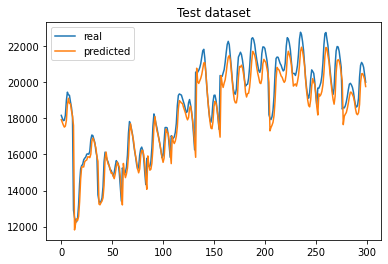

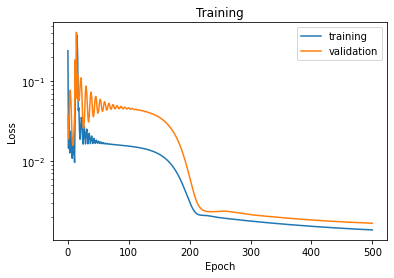

In [9]:
predicted = []
for test_seq in x_test.tolist():
    x = torch.Tensor(data = [test_seq])
    # passing hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2))
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    predicted.append(unscaled)

real = scaler.inverse_transform(y_test.tolist())
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()

plt.title('Training')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [10]:
class GRU(nn.Module):
    
    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

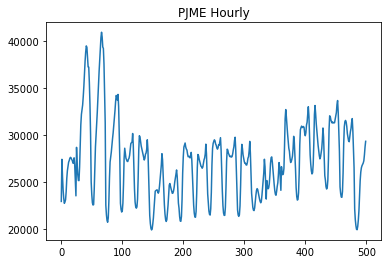

In [11]:
plt.title('PJME Hourly')
plt.plot(get_pjme_timeseries()[:500])
plt.show()


epoch 0: train - 0.0152, val: - 0.0272
epoch 50: train - 0.0015, val: - 0.0022
epoch 100: train - 0.0007, val: - 0.0018
epoch 150: train - 0.0006, val: - 0.0016
epoch 200: train - 0.0006, val: - 0.0016
epoch 250: train - 0.0006, val: - 0.0015
epoch 300: train - 0.0006, val: - 0.0014
epoch 350: train - 0.0005, val: - 0.0014
epoch 400: train - 0.0005, val: - 0.0012
epoch 450: train - 0.0005, val: - 0.0014


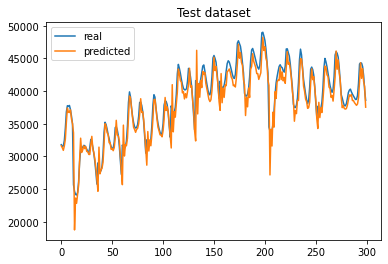

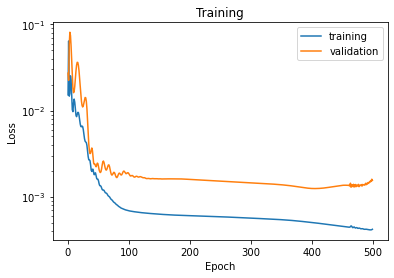

In [12]:
random.seed(1)
torch.manual_seed(1)

# PARAMETERS

# length of sliding window
features = 240
# length of test dataset
test_ts_len = 300
# size of GRU hidden state
gru_hidden_size = 24
# Optimizer learning rate
learning_rate = 0.02

training_epochs = 500

# Preparing datasets for Training
ts = get_pjme_timeseries()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(scaled_ts, features, test_ts_len)

# Initializing the model
model = GRU(hidden_size = gru_hidden_size)
model.train()

# Training
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):

    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 50 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')

best_model.eval()
_, h_list = best_model(x_val)
# warm hidden state
h = (h_list[-1, :]).unsqueeze(-2)

predicted = []
for test_seq in x_test.tolist():
    x = torch.Tensor(data = [test_seq])
    # passing hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2))
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    predicted.append(unscaled)

real = scaler.inverse_transform(y_test.tolist())
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()

plt.title('Training')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

epoch 0: train - 0.0443, val: - 0.0546
epoch 10: train - 0.0213, val: - 0.0285
epoch 20: train - 0.0095, val: - 0.0107
epoch 30: train - 0.0039, val: - 0.0043
epoch 40: train - 0.0024, val: - 0.003
epoch 50: train - 0.0018, val: - 0.0025
epoch 60: train - 0.0014, val: - 0.0021
epoch 70: train - 0.0012, val: - 0.0019
epoch 80: train - 0.0011, val: - 0.0018
epoch 90: train - 0.0011, val: - 0.0018
epoch 100: train - 0.0011, val: - 0.0018
epoch 110: train - 0.001, val: - 0.0017
epoch 120: train - 0.001, val: - 0.0017
epoch 130: train - 0.001, val: - 0.0017
epoch 140: train - 0.0009, val: - 0.0018
epoch 150: train - 0.0009, val: - 0.0022
epoch 160: train - 0.0008, val: - 0.0039
epoch 170: train - 0.0008, val: - 0.01
epoch 180: train - 0.0009, val: - 0.0022
epoch 190: train - 0.0009, val: - 0.003


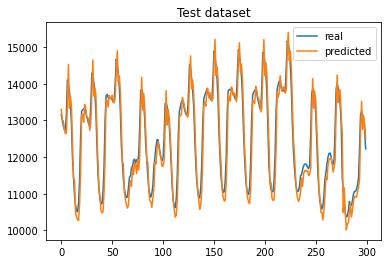

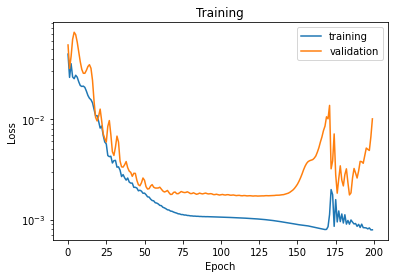

In [13]:
import copy
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
# from ch4.model.lstm import LSTM
# from ch4.training_datasets import get_training_datasets, get_ni_timeseries

random.seed(1)
torch.manual_seed(1)

# PARAMETERS

# length of sliding window
features = 240
# length of test dataset
test_ts_len = 300
# size of LSTM hidden state
lstm_hidden_size = 24
# Optimizer learning rate
learning_rate = 0.02

training_epochs = 200

# Preparing datasets for Training
ts = get_ni_timeseries()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(scaled_ts, features, test_ts_len)

# Initializing the model
model = LSTM(hidden_size = lstm_hidden_size)
model.train()

# Training
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):

    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')

best_model.eval()
with torch.no_grad():
    _, h_list = best_model(x_val)
    # warm hidden and cell state
    h = tuple([(h[-1, -1, :]).unsqueeze(-2).unsqueeze(-2)
               for h in h_list])

    predicted = []
    for test_seq in x_test.tolist():
        x = torch.Tensor(data = [test_seq])
        # passing hidden state and cell through each iteration
        y, h = best_model(x, h)
        unscaled = scaler.inverse_transform(
            np.array(y.item()).reshape(-1, 1))[0][0]
        predicted.append(unscaled)

real = scaler.inverse_transform(y_test.tolist())
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()

plt.title('Training')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()